<big><strong><a href="https://www.kaggle.com/c/spaceship-titanic/data" target="_blank">Spaceship Titanic</a></strong></big>
<br/>
<big>Predict which passengers are transported to an alternate dimension</big>

**TODO**:
- [ ] Figure out if the categorical values among the ones have any dependency or correlation with other attributes
- [ ] Make appropriate models to predict the missing values.

**Getting started with a `Data Science` projects**

- Get to know the dataset using `Excel` or something
- Perform initial lookup
    - `head()`
    - `info()`
    - `describe()`
- Get into `EDA`
    - Perform univariate analysis (Analysis on a single variable)
        - `Categorical variables`
            - `Count plots`
        - `Continuous variables`
            - `Histograms`
            - `Distribution plots` (usually normalized)
    - Perform multivariate analysis (Analysis on two variables, )
        - All combinations of `Categorical` and `Continuous` variables (`cat-con`, `cat-cat`, `con-con`)
- Perform missing value analysis
    - Look into type of missing values
        - `Missing at random` (**MAR**)
        - `Missing not at random` (**MNAR**)
        - `Missing completely at random` (**MCAR**)
    - Handling random values
        - Dropping the rows
        - Inpute
            - Dumb way of doing things (Imputing with the mean, median, mode)
            - Predict
                - `Categorical` (Supervised categorical)
                - `Continuous` (Supervised regression)

## Imports

In [411]:
# Built-in imports
import warnings
from typing import List, Tuple, Dict

warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Data visualizations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Documentations
from IPython.display import Markdown, display

sns.set_style('whitegrid')

# MODE OF THE NOTEBOOK
# 'G' means seaborn plots will be plotted, else plotly.express will be used
MODE: str = 'G'

## Reading the training dataset (`train.csv`)

In [412]:
# Contents of the data directory (similar to Kaggle)
!ls ../data

sample_submission.csv
test.csv
train.csv


In [413]:
# Reading the dataset
df = pd.read_csv('../data/train.csv')
num = df.shape

## Initial lookup

In [414]:
# Initial lookup
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [416]:
df.describe(percentiles=[.99, .75, .5, .33, .25, .1])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
33%,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
99%,65.000000,3096.230000,8033.310000,2333.440000,5390.100000,5646.680000


## Variable Identification

In this stage our goal is to determine the _"types"_ of variables.

In [417]:
print('COLUMN', 'TYPE'.rjust(24, ' '))
print('~'*31)
for c in df.columns:
    t = 'Continuous' if df[c].nunique() > 10 else 'Categorical'
    print(c, t.rjust(30 - len(c), '-'))

COLUMN                     TYPE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PassengerId ---------Continuous
HomePlanet ---------Categorical
CryoSleep ----------Categorical
Cabin ---------------Continuous
Destination --------Categorical
Age -----------------Continuous
VIP ----------------Categorical
RoomService ---------Continuous
FoodCourt -----------Continuous
ShoppingMall --------Continuous
Spa -----------------Continuous
VRDeck --------------Continuous
Name ----------------Continuous
Transported --------Categorical


## Exploratory Data Analysis

### Univariate Analysis

In [418]:
# Functions used for univariate analysis

def px_countplot(column: str) -> pd.DataFrame:
    temp = df.groupby(column).size().reset_index(name='Counts')
    fig = px.bar(temp, x=column, y='Counts', title=f'Countplot of <b>{column}</b>'); fig.show()
    return temp

def sns_countplot(column: str, **kwargs) -> None:
    sns.countplot(x=df[column], **kwargs)
    plt.title(f'Countplot of {column}'); plt.ylabel('Counts')
    plt.show()

def px_histplot(column: str, nbins=30) -> pd.DataFrame:
    fig = px.histogram(df, x=column, nbins=nbins, title=f'Distribution of <b>{column}</b>')
    fig.update_layout(bargap=0.1); fig.show()

def sns_histplot(column: str, type='hist', **kwargs) -> None:
    if type == 'hist':
        sns.histplot(x=df[column], color='red', kde=True)
    else:
        sns.distplot(a=df[column], color='red')
    plt.title(f'Distribution of {column}'); plt.show()

#### `PassengerId`

A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

In [419]:
# Looking at individual columns
df.PassengerId
# This takes the form of gggg_pp,
# where gggg indicates a group the passenger is travelling with and `pp` is their
# number within the group.

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

Creating attribute `GroupId` and `PassengerId`

In [420]:
# FEATURE ENGINEERING
# Splitting PassengerId into GroupID and PassengerId

df['GroupId'] = df.PassengerId.apply(lambda x: x.split('_')[0])
df['PassengerId'] = df.PassengerId.apply(lambda x: x.split('_')[1])

#### `HomePlanet`
The planet the passenger departed from, typically their planet of permanent residence.

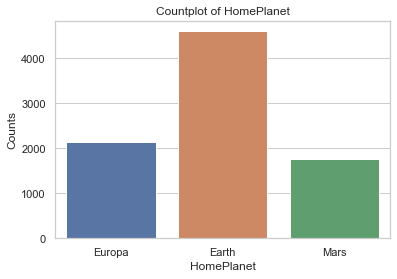

In [421]:
sns_countplot('HomePlanet') if MODE == 'G' else px_countplot('HomePlanet')

#### `CryoSleep`
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

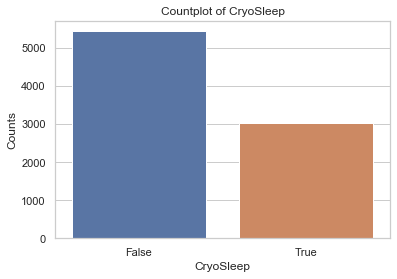

In [422]:
sns_countplot('CryoSleep') if MODE == 'G' else px_countplot('CryoSleep')

#### `Cabin`
The cabin number where the passenger is staying. Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.

In [423]:
# Breaking Cabin into deck, num and side
decks, nums, sides = [], [], []
lists = [decks, nums, sides]
for _, row in df.iterrows():
    if pd.isna(row.Cabin):
        for l in lists:
            l.append(np.nan)
    else:
        x = row.Cabin.split('/')
        for i, l in enumerate(lists):
            l.append(x[i])

df['Deck'] = decks
df['Num'] = nums
df['Side'] = sides

# Typecasting num values to int wherever possible, else keeping nan
df['Num'] = df.Num.apply(lambda x: int(x) if not pd.isna(x) else np.nan)

##### `Deck`

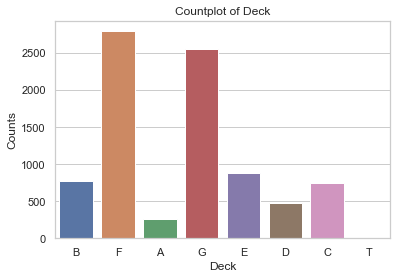

In [424]:
sns_countplot('Deck') if MODE == 'G' else px_countplot('Deck')

##### `Num`
Number of occupants of the cabin

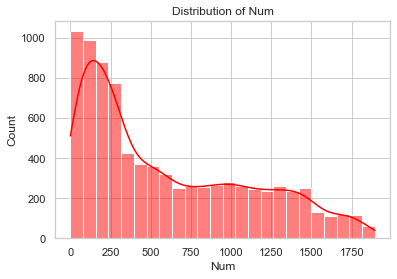

In [425]:
sns_histplot('Num') if MODE == 'G' else px_histplot('Num', nbins=40)

##### `Side`
At which side of the ship the cabin was located.
* `P` implies **Port**
* `S` implies **Starboard**

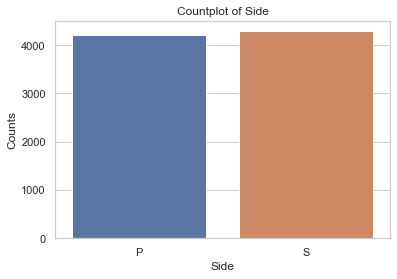

In [426]:
sns_countplot('Side') if MODE == 'G' else px_countplot('Side') 

#### `Destination`
The planet the passenger will be debarking to.

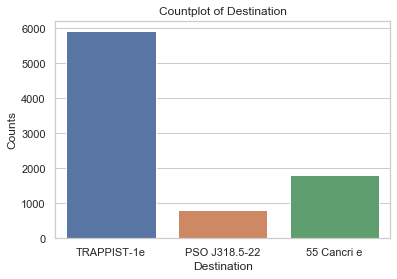

In [427]:
sns_countplot('Destination') if MODE == 'G' else px_countplot('Destination')

#### `Age`
The age of the passenger.

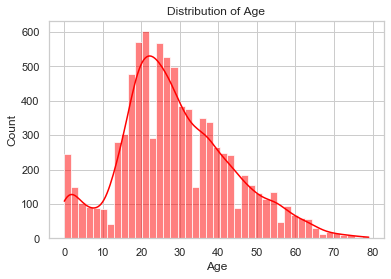

In [428]:
sns_histplot('Age') if MODE == 'G' else px_histplot('Age', nbins=35)

#### `VIP`
Whether the passenger has paid for special VIP service during the voyage.

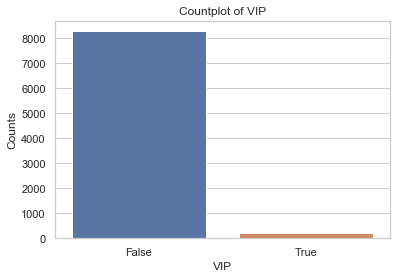

In [429]:
sns_countplot('VIP') if MODE == 'G' else px_countplot('VIP')

#### `RoomService`

Amount the passenger has billed at the room service.

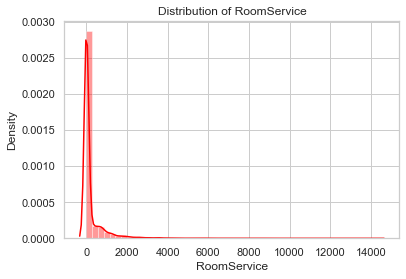

In [430]:
sns_histplot('RoomService', type='dist') if MODE == 'G' else px_histplot('RoomService', nbins=20)

#### `FoodCourt`
Amount the passenger has billed at the food court.

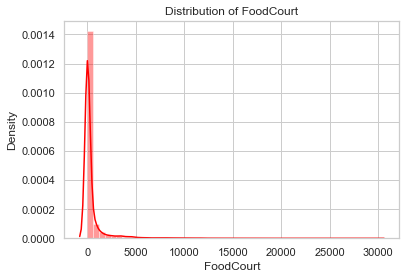

In [431]:
sns_histplot('FoodCourt', type='dist') if MODE == 'G' else px_histplot('FoodCourt', nbins=20)

#### `ShoppingMall`
Amount the passenger has billed at the shopping mall.

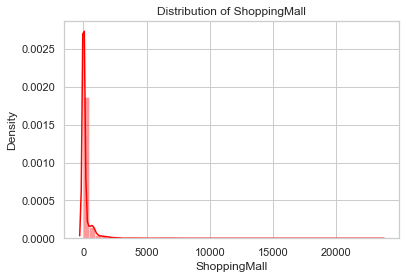

In [432]:
sns_histplot('ShoppingMall', type='dist') if MODE == 'G' else px_histplot('ShoppingMall', nbins=30)

#### `Spa`
Amount the passenger has billed at the spa.

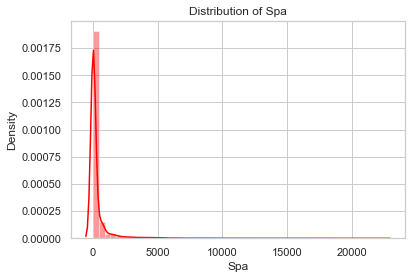

In [433]:
sns_histplot('Spa', type='dist') if MODE == 'G' else px_histplot('Spa', nbins=30)

#### `VRDeck`
Amount the passenger has billed at the VR deck.

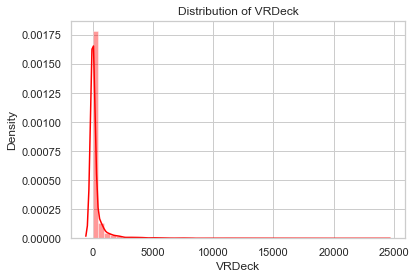

In [434]:
sns_histplot('VRDeck', type='dist') if MODE == 'G' else px_histplot('VRDeck', nbins=30)

#### `Transported`
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

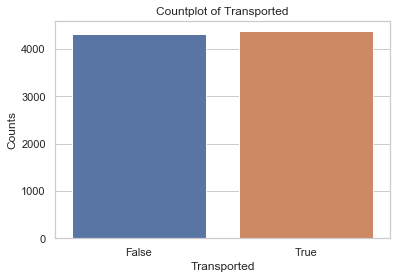

In [435]:
sns_countplot('Transported') if MODE == 'G' else px_countplot('Transported')

### Bivariate Analysis
Trying to find empirical relationshop between the attributes present in our dataset...

In [436]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Num,Side
0,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0.0,P
1,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0.0,S
2,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0.0,S


In [437]:
def contingency_table(col1, col2, ret=True, show=False, transpose=False, **kwargs) -> str:
    temp = pd.crosstab(
        df[col1], df[col2]
    )
    if transpose: temp = temp.T
    sns.heatmap(
        temp, annot=True, fmt='.0f', **kwargs
    )
    if show:
        plt.show()
    return f'Contingency table for {col1} & {col2}'

#### Some contingency tables...

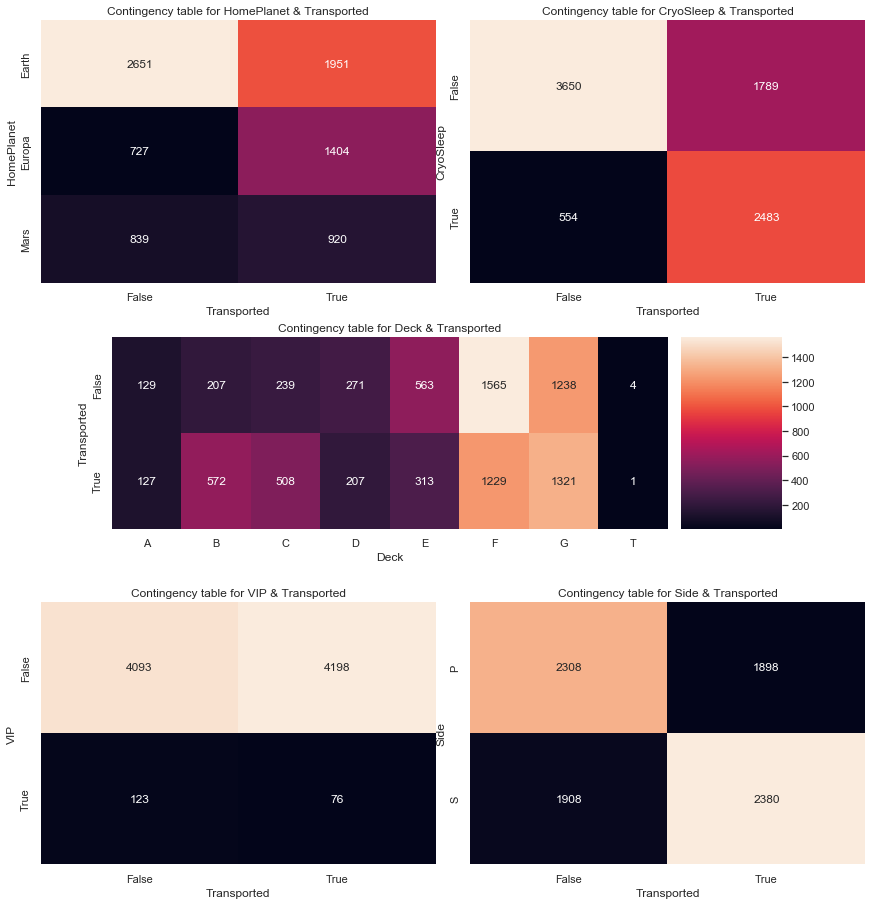

In [438]:
fig = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = fig.add_gridspec(3, 2)

a0 = fig.add_subplot(gs[0,0])
s = contingency_table('HomePlanet', 'Transported', ax=a0, cbar=False)
a0.set_title(s)

a1 = fig.add_subplot(gs[0,1])
s = contingency_table('CryoSleep', 'Transported', ax=a1, cbar=False)
a1.set_title(s)

a2 = fig.add_subplot(gs[1,:])
s = contingency_table('Deck', 'Transported', ax=a2, transpose=True)
a2.set_title(s)

a3 = fig.add_subplot(gs[2, 0])
s = contingency_table('VIP', 'Transported', ax=a3, cbar=False)
a3.set_title(s)


a4 = fig.add_subplot(gs[2, 1])
s = contingency_table('Side', 'Transported', ax=a4, cbar=False)
a4.set_title(s)

plt.show()

**Scatter plots**

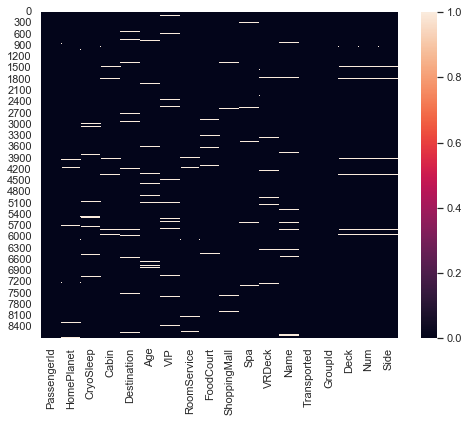

In [439]:
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.isna(df))

Lets see if there exists any relation between `RoomService` and `FoodCourt`

<Figure size 1080x1080 with 0 Axes>

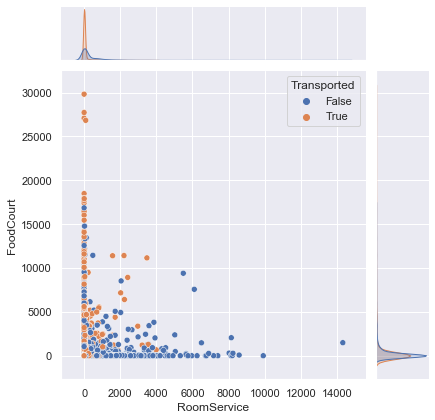

In [440]:
# if MODE == "G":
#     sns.scatterplot('RoomService', 'FoodCourt', data=df); plt.show()
# else:
#     f = px.scatter(df, 'RoomService', 'FoodCourt'); f.show()

plt.figure(figsize=(15, 15))
# sns.scatterplot('RoomService', 'FoodCourt', data=df, hue='Transported')

sns.jointplot('RoomService', 'FoodCourt', data=df, hue='Transported')

In [441]:
px.scatter(df, 'Age', 'FoodCourt', color='Transported', trendline='ols')

Creating new attribute `TotalSpent`

Using the attributes `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` to compute the `TotalSpent` values. First let us check if the columns have any nulls, in that case we'd have to replace them with `0.0`

In [442]:
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   8512 non-null   float64
 1   FoodCourt     8510 non-null   float64
 2   ShoppingMall  8485 non-null   float64
 3   Spa           8510 non-null   float64
 4   VRDeck        8505 non-null   float64
dtypes: float64(5)
memory usage: 339.7 KB


Filling in missing values in the nulls

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age
VIP,,,,,,
False,217.218527,426.336536,173.876298,301.711045,282.718056,28.639611
True,473.615385,1811.393782,247.726804,760.710660,1234.856410,37.449495


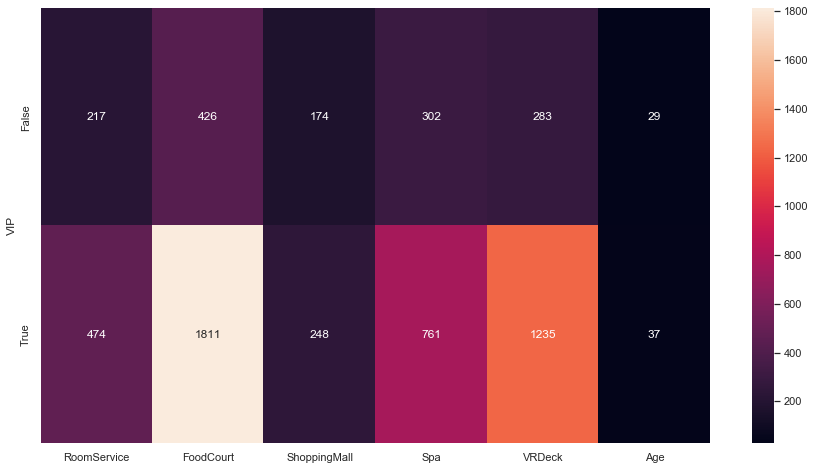

In [443]:
plt.figure(figsize=(15, 8))

vip_gb = df.groupby('VIP').mean()
vip_gb = vip_gb[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] + ['Age']]

sns.heatmap(vip_gb, annot=True, fmt='.0f')
vip_gb

In [444]:
# VIPs in the rows where RoomService values are missing...

df[pd.isna(df.RoomService)].VIP.value_counts()

False    173
True       4
Name: VIP, dtype: int64

## Missing Value Analysis

Let's see the percentages of nulls in the columns...

In [445]:
strings = [
    '|#|Column|Percentage of nulls|Type|',
    '|:|:-----|:------------------|:---|'
]
for idx, c in enumerate(df.columns, start=1):
    missing_c = df[pd.isna(df[c])]
    strings.append('|{}|{}|{}%|`{}`|'.format(
        idx, c, round((missing_c.shape[0] / num[0]) * 100, 3),
        'Continuous' if df[c].nunique() > 10 else 'Categorical'
    ))

display(Markdown('\n'.join(strings)))

|#|Column|Percentage of nulls|Type|
|:|:-----|:------------------|:---|
|1|PassengerId|0.0%|`Categorical`|
|2|HomePlanet|2.312%|`Categorical`|
|3|CryoSleep|2.496%|`Categorical`|
|4|Cabin|2.289%|`Continuous`|
|5|Destination|2.094%|`Categorical`|
|6|Age|2.059%|`Continuous`|
|7|VIP|2.335%|`Categorical`|
|8|RoomService|2.082%|`Continuous`|
|9|FoodCourt|2.105%|`Continuous`|
|10|ShoppingMall|2.393%|`Continuous`|
|11|Spa|2.105%|`Continuous`|
|12|VRDeck|2.163%|`Continuous`|
|13|Name|2.301%|`Continuous`|
|14|Transported|0.0%|`Categorical`|
|15|GroupId|0.0%|`Continuous`|
|16|Deck|2.289%|`Categorical`|
|17|Num|2.289%|`Continuous`|
|18|Side|2.289%|`Categorical`|

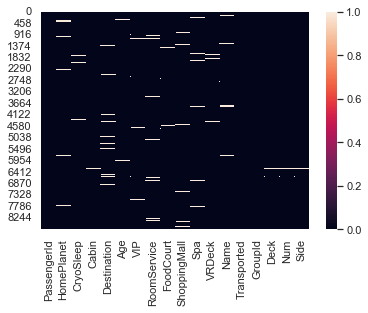

In [446]:
sns.heatmap(pd.isna(df))

### [FEATURE ENGINEERING] `LastName`

In [447]:
def get_last_name(name: str) -> str:
    if pd.isna(name): return ''
    else: return name.split(' ')[1]

In [448]:
df['LastName'] = df.Name.apply(lambda x: get_last_name(x))

In [449]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Num,Side,LastName
0,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0.0,P,Ofracculy
1,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0.0,S,Vines
2,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0.0,S,Susent


### [TYPECASTING] `GroupId` to `int`

In [450]:
df.GroupId = df.GroupId.apply(lambda x: int(x))

### Writing necessary methods

In [451]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [452]:
def get_encoder_dictionary(df: pd.DataFrame, encode_cols: List[str], **kwargs) -> Dict[str, LabelEncoder]:
    encoders: Dict[str, LabelEncoder] = {}
    
    # For every column we're fitting the encoder
    # with all non null values and save it in the
    # encoders dictionary with the key `column`
    for column in encode_cols:
        l = LabelEncoder(**kwargs)
        non_null_values: List[Any] = df[~pd.isna(df[column])][column].tolist()
        l.fit(non_null_values)
        encoders[column] = l
    
    return encoders

In [453]:
def test_model(X, y, model, type_, target, ax):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    if type_ == 'C':
        sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='.0f', 
                    ax=ax, linewidth=2, cbar=False)
        ax.set_title('[{}] Confusion-matrix (Accuracy: {})'.format(
            target, accuracy_score(y_test, preds), fontsize=50
        ))
    else:
        mse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        sm.qqplot(y_test-preds, fit=True, line='45', ax=ax, markersize=10)
        ax.set_title('[{}] QQ-Plot (RMSE: {} - MAE: {})'.format(
            target, round(np.sqrt(mse), 3), round(mae, 3)
        ))
    return

In [454]:
# Columns to exclude
exclude_cols = ['PassengerId', 'Cabin', 'Name', 'Transported']

def impute_with_model(
    df: pd.DataFrame,
    target: str,
    encoders: Dict[str, LabelEncoder],
    type_: str = 'C',
    test: bool = True,
    ax=None
) -> pd.DataFrame:

    # Exit condition
    if df[pd.isna(df[target])].shape[0] == 0:
        return df
    
    model = DecisionTreeClassifier() if type_ == 'C' else LinearRegression()
    # Columns that're to be used for this model
    include_cols = [x for x in df.columns if x not in exclude_cols]
    
    # Making a copy of the dataframe
    temp = df[include_cols].copy(deep=True)
    temp.dropna(inplace=True)
    
    for c in temp.columns:
        if c in encoders:
            temp[c] = encoders[c].transform(temp[c])
    
    X, y = (temp[[x for x in df.columns if x not in exclude_cols + [target]]], 
            temp[target])
    
    # NOT WORKING CURRENTLY
    if test and ax:
        f = test_model(X, y, model, type_, target, ax)

    # Final training
    model.fit(X, y)
    # Processing the entire dataframe for prediction
    X_new = df[pd.isna(df[target])][X.columns].dropna()
    # Selecting only those rows
#     X_new = X_new[X.columns].dropna()
    
    # Encoding values for prediction
    for column, encoder in encoders.items():
        if column in X_new.columns:
            X_new[column] = encoder.transform(X_new[column])
    # Making predictions
    preds = model.predict(X_new)
    labels = encoders[target].inverse_transform(preds) if (
        type_ == 'C'
    ) else df[target].tolist()
    # Adding the predictions to respective columns
    idx_preds_mapping: List[Tuple[int, str]] = list(zip(X_new.index.tolist(), labels))
    for idx, p in idx_preds_mapping:
        df.loc[df.index==idx, target] = p
    # For the rest of the missing attributes we're imputing with mode or 
    # median depending on the type of var
    x = df[target].mode().iloc[0] if type_ == 'C' else df[target].median()
    df.loc[pd.isna(df[target]), target] = x
    return df


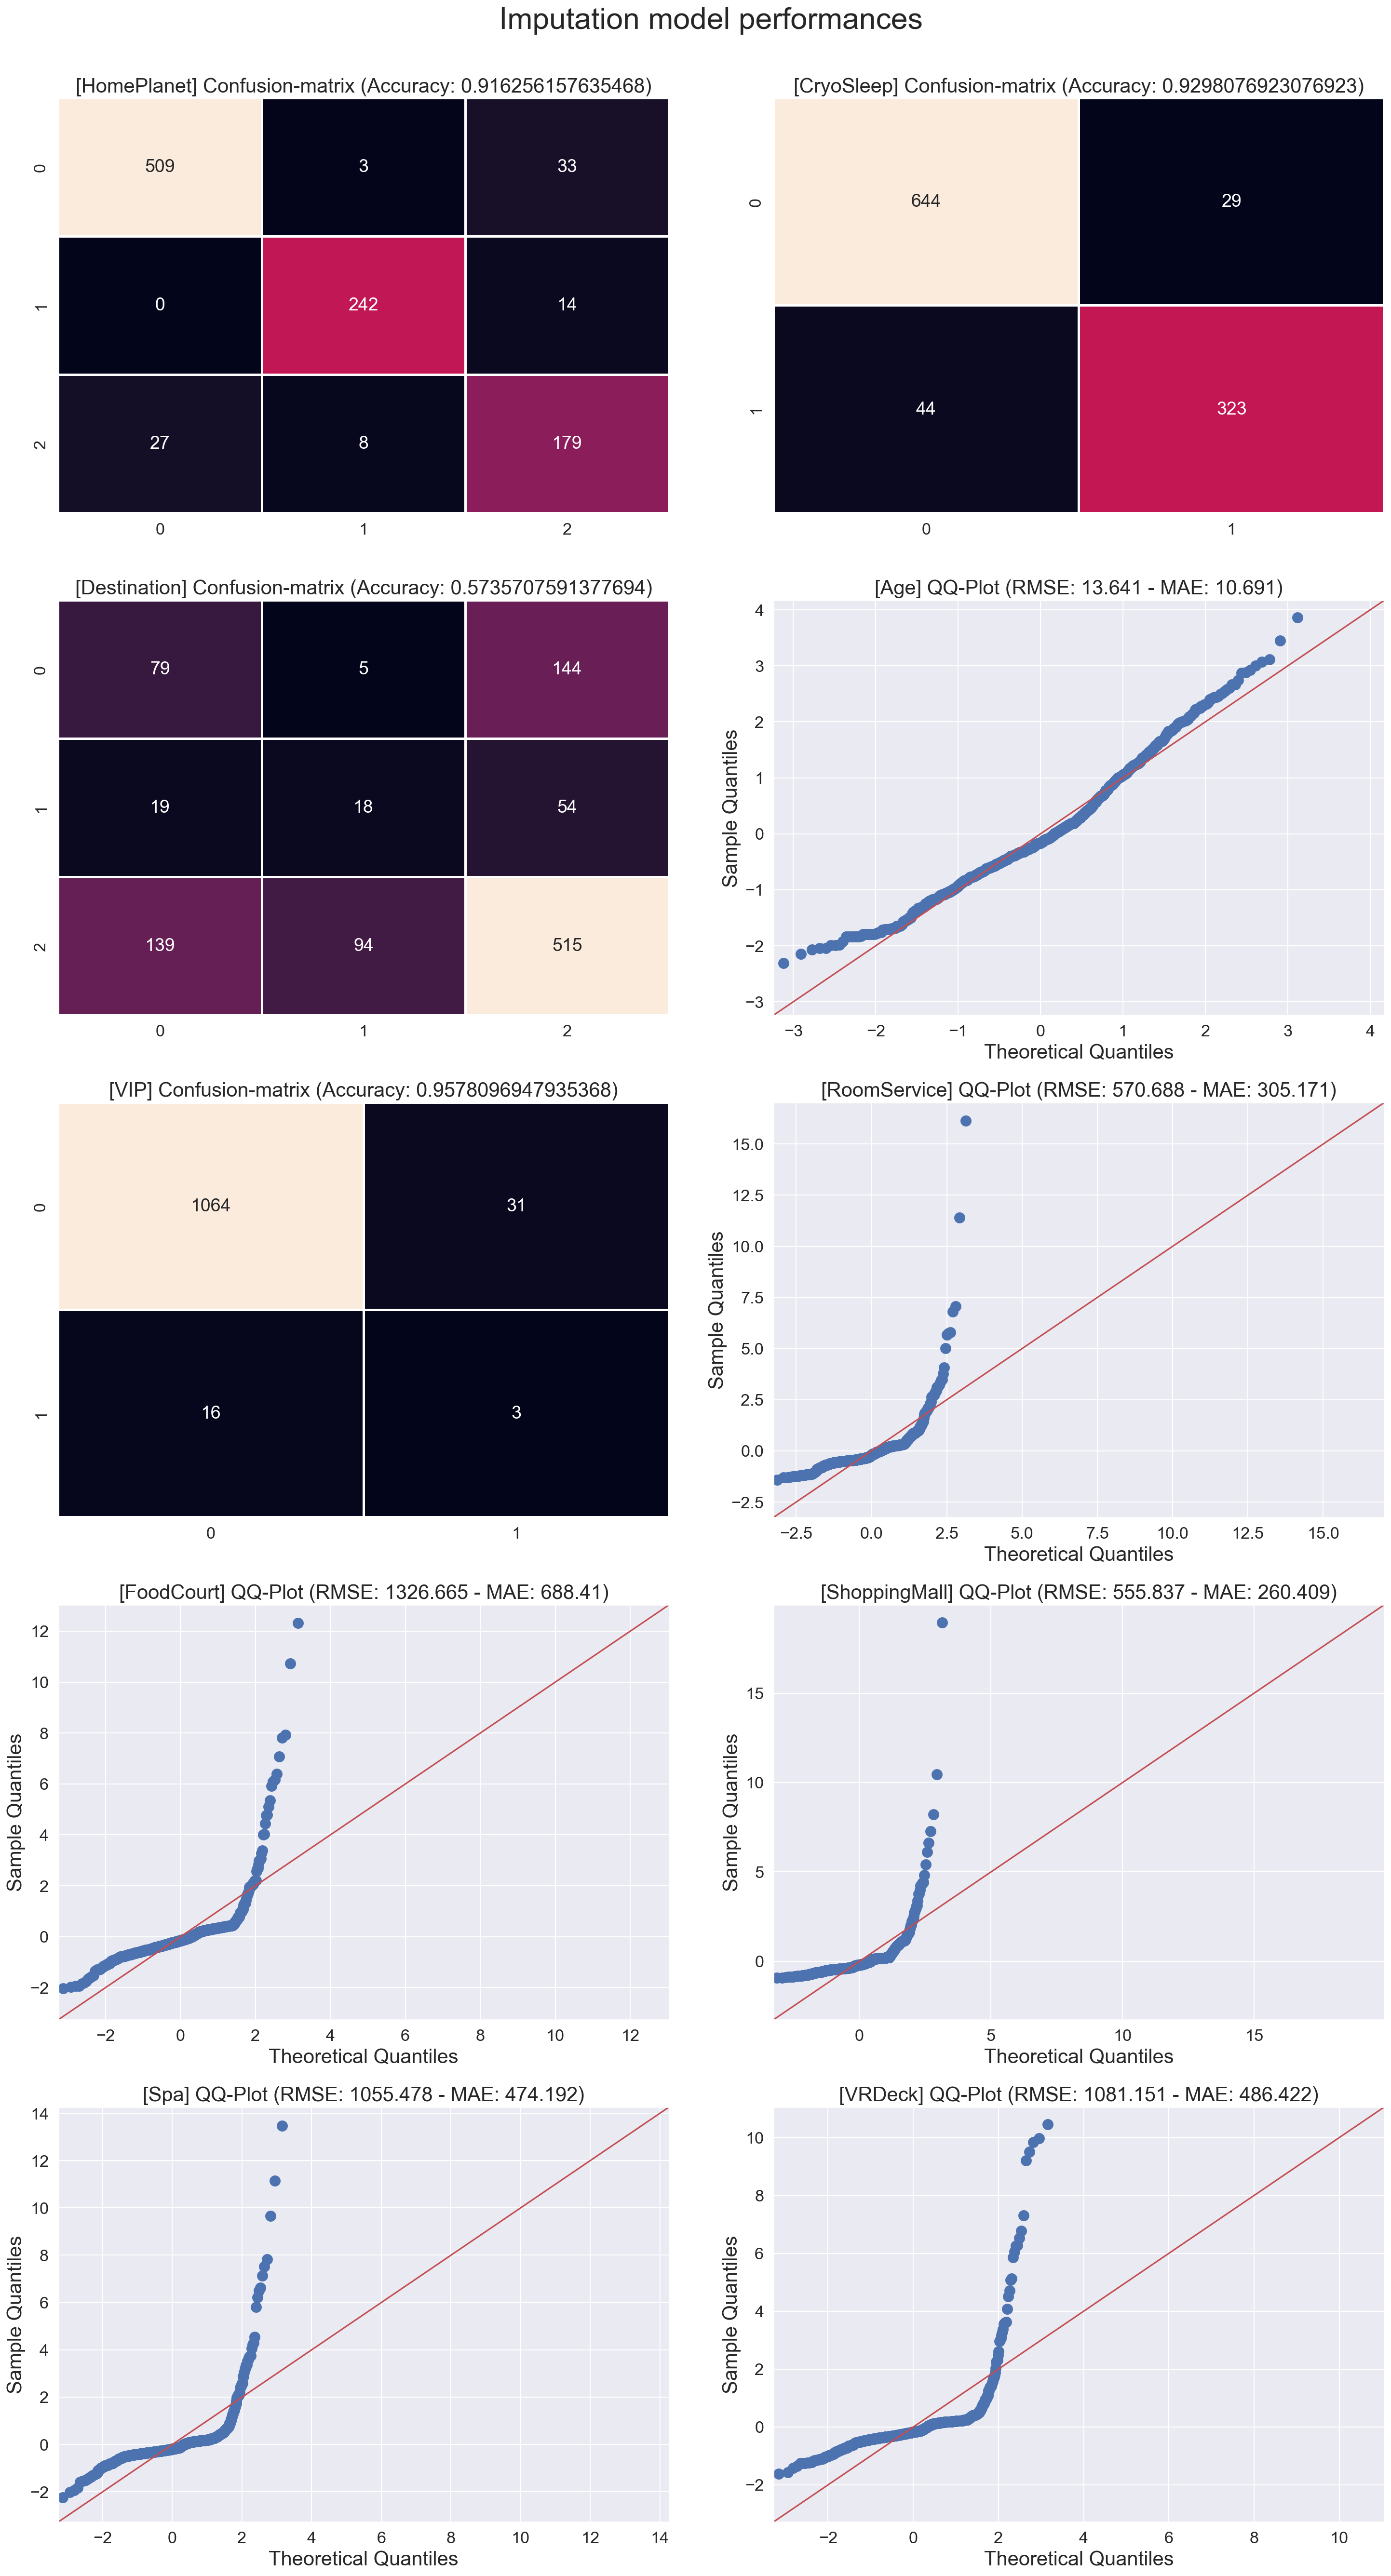

In [455]:
encoder_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Deck', 'Side', 'LastName']
encoders = get_encoder_dictionary(df, encoder_cols)

NROWS, NCOLS = 5, 2
sns.set(font_scale=1.5)
_, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, dpi=150, figsize=(20, 35))

# Columns that we'd have to impute
cols_to_impute = [
    ('HomePlanet', 'C'), ('CryoSleep', 'C'), ('Destination', 'C'),
    ('Age', 'R'), ('VIP', 'C'), ('RoomService', 'R'), ('FoodCourt', 'R'), 
    ('ShoppingMall', 'R'), ('Spa', 'R'), ('VRDeck', 'R')
]

idx = 0
for i in range(NROWS):
    for j in range(NCOLS):
        col, type_ = cols_to_impute[idx]
        df = impute_with_model(df, col, encoders, type_, test=True, ax=ax[i][j])
        ax[i][j].title.set_fontsize(20)
        ax[i][j].xaxis.label.set_fontsize(20)
        ax[i][j].yaxis.label.set_fontsize(20)
        idx += 1

plt.suptitle('Imputation model performances', x=0.5, y=1.02, fontsize=30)
plt.tight_layout()

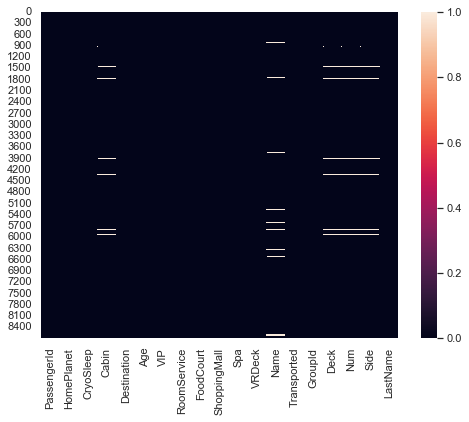

In [456]:
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.isna(df))